MNIST SGD

1. download pickle file using http://deeplearning.net/data/mnist/mnist.pkl.gz link
2. set the path and assign variable
3. draw random data of x_train
4. make it to pytorch’s tensor
5. and create databunch(size=64)
6. see first bunch of data
7. make class Mnist logistic which do multiplication
8. make model to gpu version and see inner function.
9. set the loss function as crossentropy
10. and make function which 1) update parameter depends on batch data. 2) add weight decay to regular loss
11. plot loss
12. another class which has hidden nn, layer = 50, use relu as activation function
13. same with 10,  but use optimization, which is adam, lr=1e-3
14. draw loss
15. do it with fast.ai


In [0]:
from fastai.basics import *

In [1]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2020-04-22 08:17:03--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  7.14MB/s    in 2.2s    

2020-04-22 08:17:06 (7.14 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [2]:
!ls

mnist.pkl.gz  sample_data


In [0]:
with gzip.open('/content/mnist.pkl.gz') as f:
    (train_x, train_y), (valid_x, valid_y), _ = pickle.load(f, encoding='latin1')

`TODO#1`: plt.imshow, parameter cmap list and channel, why it colors like that

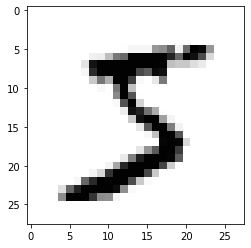

In [16]:
plt.imshow(train_x[0].reshape(28,28), cmap='Greys')

In [22]:
type(train_x)

numpy.ndarray

In [0]:
train_x, train_y, valid_x, valid_y = map(torch.tensor, (train_x, train_y, valid_x, valid_y))

In [24]:
train_x.type()

'torch.FloatTensor'

In [0]:
#5
TensorDataset??

In [0]:
train_dl = TensorDataset(train_x, train_y)

In [0]:
valid_dl = TensorDataset(valid_x, valid_y)

In [31]:
ds = DataBunch.create(train_dl, valid_dl, bs=64); ds

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f52effa7438>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f52eff83198>;

Test: None

In [32]:
#6
next(iter(ds))

TypeError: ignored

In [33]:
iter(next(ds))

TypeError: ignored

In [0]:
train_x, train_y = next(iter(ds.train_dl))

In [41]:
train_x.shape, train_y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
#7
class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
    def forward(self, xb):
        return self.lin(xb)

In [0]:
#8
model = MnistLogistic().cuda()

In [51]:
model(train_x).shape

torch.Size([64, 10])

In [52]:
model = MnistLogistic(); model(train_x)

RuntimeError: ignored

`TODO#2` : why it expected `device type=cude`?, because of nn.Module? / I didn't specify it would be `cuda`
> RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_addmm

In [0]:
#9
loss_func = nn.CrossEntropyLoss()
lr = 1e-02

In [0]:
#10
# absolutely wrong
def update(xb, yb, lr):
    y_hat = model(xb)
    wd = 1e-03
    w = 0.
    for p in model.parameter(): w += wd*p.grad
    loss = loss_func(y_hat, yb)**2 + w
    loss.backward() #calculate gradient
    with torch.autograd(requires_grad=False):
        p.sub_(lr * p.grad)
        p.grad = 0

`TODO#3`: was this online batch?> if then, why?

In [0]:
def update(xb, yb, lr):
    y_hat = model(xb)
    wd = 1e-05
    w2=0.
    for p in model.parameters(): w2 += (p**2).sum()
    loss = loss_func(y_hat, yb) + wd*w2
    loss.backward()
    with torch.no_grad(): # `TODO#4` what is this?
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
loss = [update(x, y, lr) for x, y in ds.train_dl]

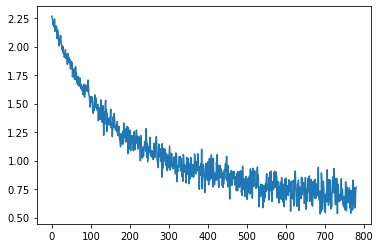

In [70]:
plt.plot(loss)

In [0]:
#12
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        self.h = self.lin1(xb)
        self.a = F.relu(self.h)
        return self.lin2(self.a)

In [0]:
model = Mnist_NN().cuda()

In [76]:
model(train_x).shape

torch.Size([64, 10])

In [0]:
def update2(xb, yb, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(xb)
    loss = loss_func(y_hat, yb)
    loss.backward()
    opt.step() # `TODO#5`is there any weight decay? because already did backward()
    opt.zero_grad()
    return loss.item()

In [0]:
loss = [update2(x, y, lr=1e-03) for x, y in ds.train_dl]

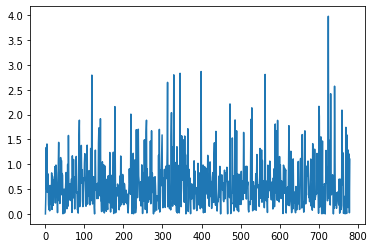

In [98]:
plt.plot(loss)

In [0]:
learn = Learner(ds,Mnist_NN(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [102]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


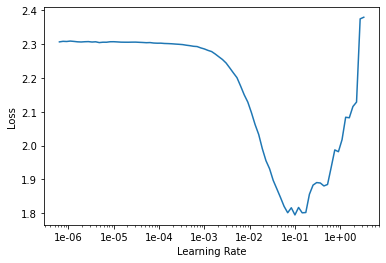

In [103]:
learn.recorder.plot()

In [105]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.161624,0.129309,0.961500,00:03


`TODO#6` 
Jeremy told this symetric graph is rule <br/> but can't understand why yet.<br/>
`My guess`:: feels like accelaration. if momentum is scalar that reflects previous learning, when I learn fast, previous history can't affect much and if I learn slow previous memory could affect much more.

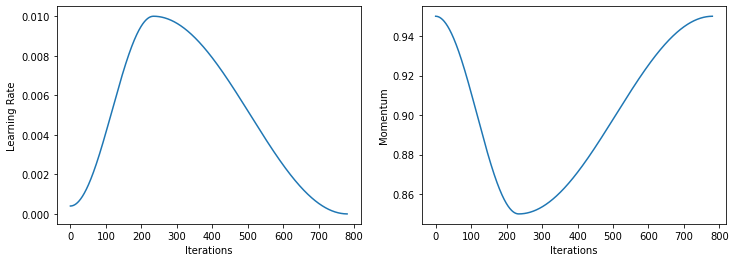

In [106]:
learn.recorder.plot_lr(show_moms=True)